In [8]:
import pandas as pd
import datamol as dm
import numpy as np

from molfeat.calc import RDKitDescriptors2D, FPCalculator, MordredDescriptors
from molfeat.trans import MoleculeTransformer

In [9]:
train_data = dm.read_csv("train_admet.csv", smiles_column="Drug", index_col=0)

[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:39] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not removing hydrogen atom without neighbors
[13:55:40] WARNING: not r

,Drug_ID,Drug,Y,property,mol
0,0,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1,1,
1,1,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0,1,
2,2,[N-]=[N+]=CC(=O)NCC(=O)NN,1,1,
3,3,[N-]=[N+]=C1C=NC(=O)NC1=O,1,1,
4,4,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1,1,
...,...,...,...,...,...
7934,7934,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1,3,
7935,7935,C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1,3,
7936,7936,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1,3,
7937,7937,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1,3,

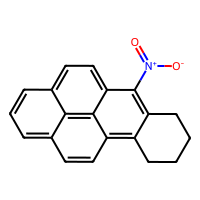
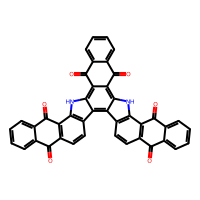
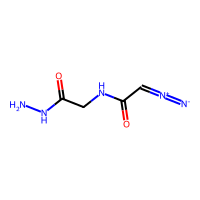
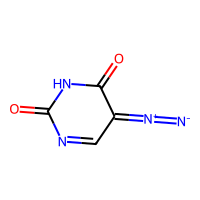
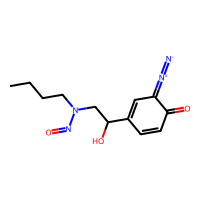
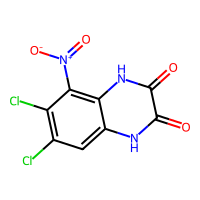
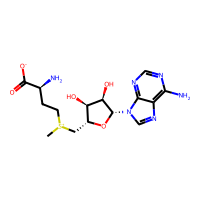
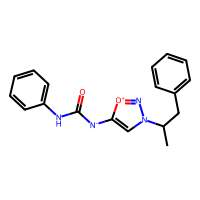
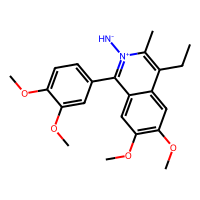
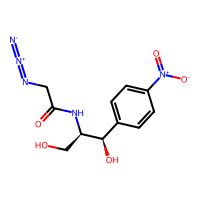

In [10]:
train_data

In [11]:
from molfeat.trans.concat import FeatConcat
from molfeat.trans.fp import FPVecTransformer

rdkit = FPVecTransformer("desc2D", n_jobs=8, dtype=np.float32, replace_nan=True)
maccs = FPVecTransformer("maccs", dtype=np.float32)
ecfp4 = FPVecTransformer("ecfp:4", dtype=np.float32)

# Wrap the calculator in a transformer instance
featurizer = FeatConcat([maccs, ecfp4, rdkit], dtype=np.float32)

with dm.without_rdkit_log():
    feats = featurizer(train_data["mol"])

C:\Users\Sasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [12]:
feats.shape

(7939, 2383)

In [13]:
feats

array([[0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 2., 0., 6.],
       ...,
       [0., 0., 0., ..., 2., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 5.]])

In [14]:
labels = train_data["Y"]
labels

0       1
1       0
2       1
3       1
4       1
       ..
7934    1
7935    1
7936    1
7937    1
7938    1
Name: Y, Length: 7939, dtype: int64

In [15]:
labels.unique()

array([1, 0], dtype=int64)

In [16]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False).fit(train_data[["property"]].to_numpy())

In [17]:
ohe.transform(train_data[["property"]].to_numpy())

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [18]:
X = np.concatenate([feats, ohe.transform(train_data[["property"]].to_numpy())], axis=-1)

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

model = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 3, 5, 7],
    'min_samples_leaf': [20, 50, 100],
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=2, cv=cv, verbose=2)


grid_search.fit(X_train, y_train)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation ROC AUC: {grid_search.best_score_}")


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Test Set Performance:")
print(classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test Set ROC AUC: {roc_auc}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 300, 'min_samples_leaf': 20}
Best Cross-Validation ROC AUC: 0.8949140927296927
Test Set Performance:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       572
           1       0.87      0.91      0.89      1016

    accuracy                           0.86      1588
   macro avg       0.85      0.83      0.84      1588
weighted avg       0.85      0.86      0.85      1588

Test Set ROC AUC: 0.9141825202356699


In [32]:
sample = pd.DataFrame({
    "id": test_data["Drug_ID"], 
    "Y": test_preds[:, 1]       
})
sample
sample.to_csv("sample_predictions.csv", index=False)